In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

# group memberships
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
print(A_t_medical_groups.sum(axis=0))

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64


In [3]:
A_t_medical_groups, A_t_medical_groups.shape

(      young  middle  old  underweight  healthyweight  overweight  obese  \
 0       1.0     0.0  0.0          0.0            0.0         1.0    0.0   
 1       1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 2       1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 3       1.0     0.0  0.0          0.0            1.0         0.0    0.0   
 4       1.0     0.0  0.0          0.0            0.0         1.0    0.0   
 ...     ...     ...  ...          ...            ...         ...    ...   
 1333    0.0     1.0  0.0          0.0            0.0         0.0    1.0   
 1334    1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 1335    1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 1336    1.0     0.0  0.0          0.0            0.0         1.0    0.0   
 1337    0.0     0.0  1.0          0.0            0.0         1.0    0.0   
 
       smoker  non-smoker  male  female  always_on  
 0        1.0         0.0   0.0  

In [4]:
age_groups = ['young', 'middle', 'old']
bmi_groups = ['underweight', 'healthyweight', 'overweight', 'obese']
A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison

,young,middle,old,underweight,healthyweight,overweight,obese
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
1333,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1334,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1335,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1336,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh[['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']] = A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
added_indicators = ['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']
np.all(df_medical_mm_oh[added_indicators + ['smoker_yes', 'smoker_no', 'sex_male', 'sex_female']].to_numpy() == A_t_medical_groups.to_numpy()[:, :11]) # checks that A_t information is all included in the dataframe! no loss of group info to baseline so a fair comparison

True

In [6]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds
ds_ob = BuildGroupwise_diffseeds(df_medical_mm_oh, 'charges', A_t_medical_groups)
ds_ob.build_all_seeds()
ds_ob.build_df_res()
ds_ob.build_regret_curve()

100%|██████████| 1338/1338 [00:00<00:00, 6024.75it/s]


In [4]:
subgroups_list = [['young', 'middle', 'old'], ['underweight', 'healthyweight', 'overweight',
       'obese'], ['smoker', 'non-smoker'], ['male', 'female'], ['always_on']]

In [5]:
# from bilevel.Groupwise_seedruns import plot_subgroups, plot_regret_curve_with_std
# plot_subgroups(plot_ob, subgroups_list)

young 574


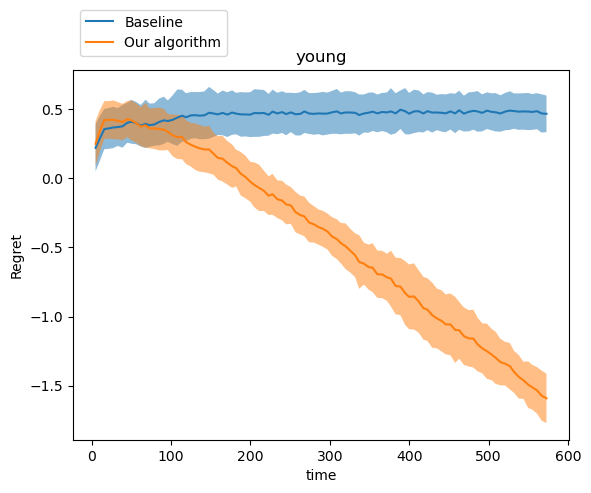

middle 408


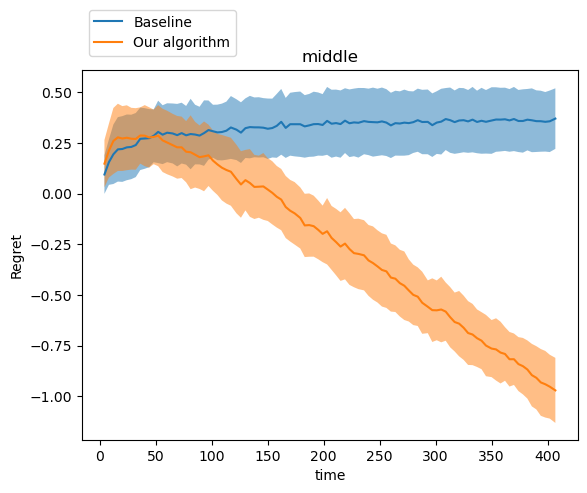

old 356


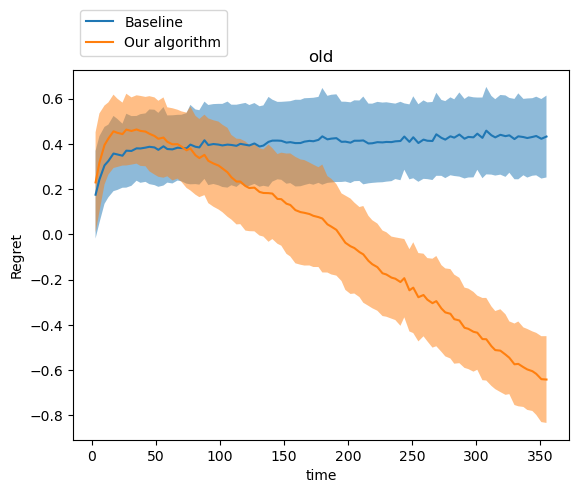

underweight 20


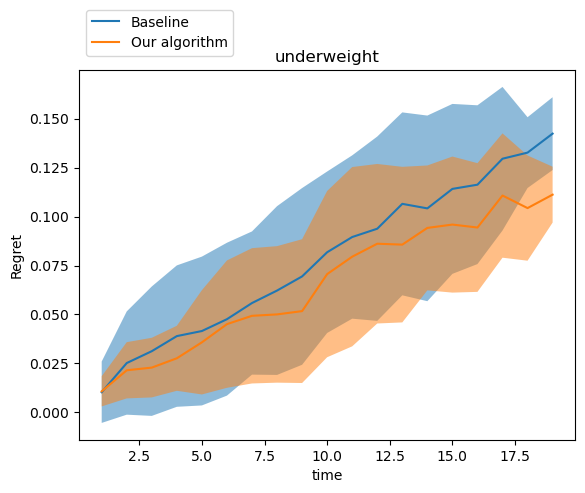

healthyweight 225


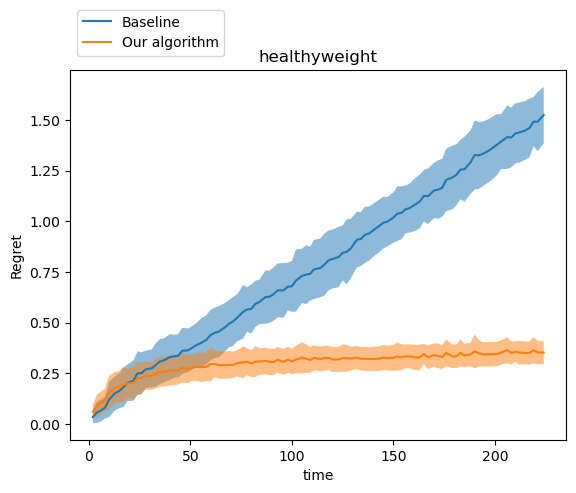

overweight 386


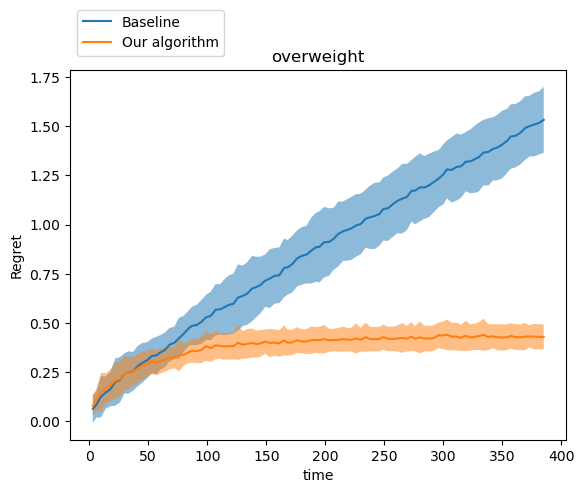

obese 707


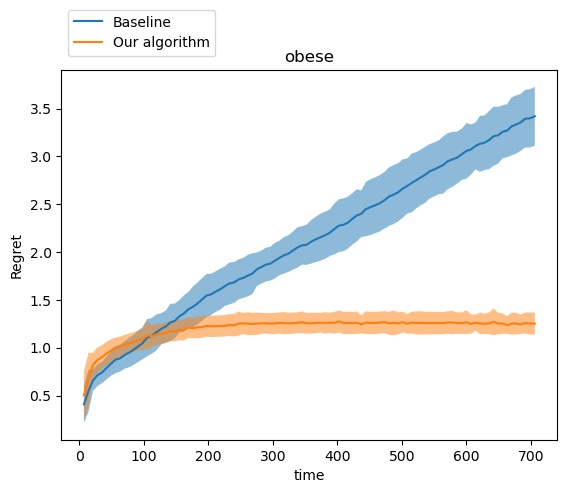

smoker 274


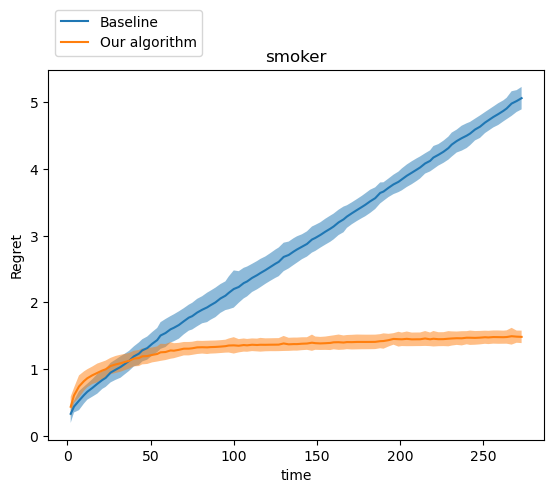

non-smoker 1064


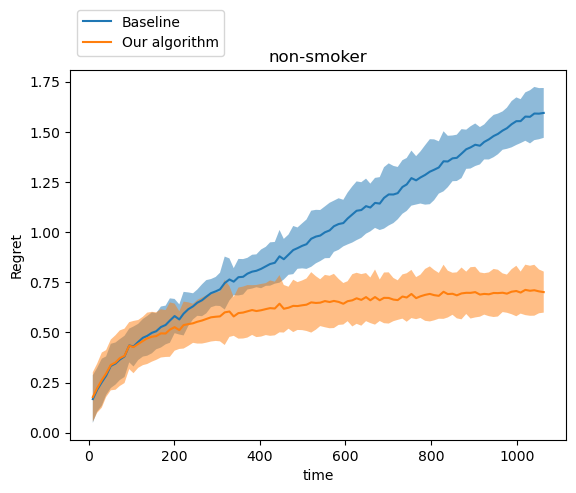

male 676


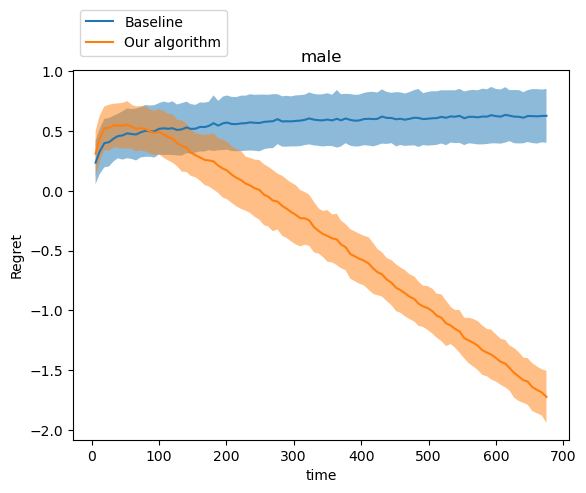

female 662


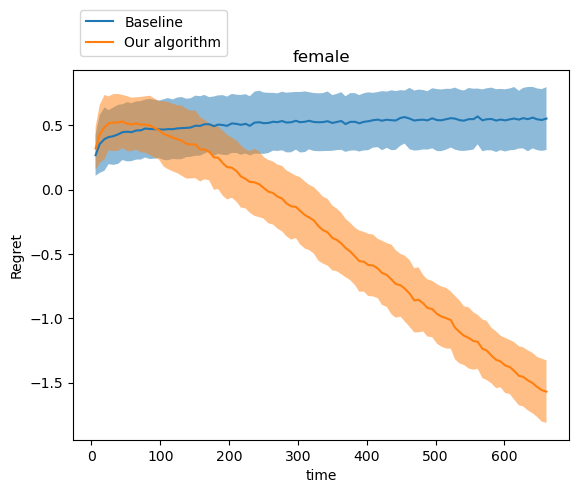

always_on 1338


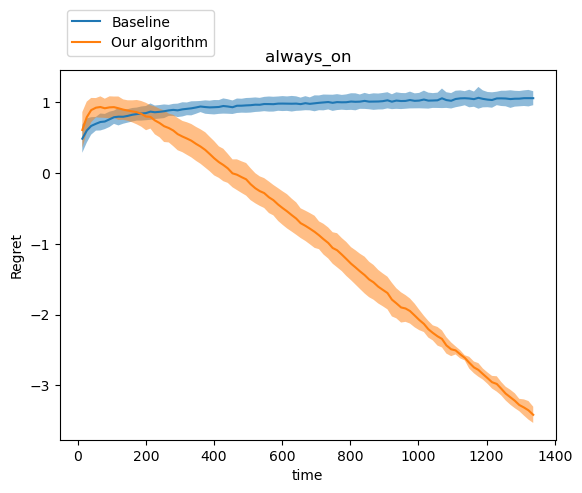

In [10]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
plot_regret_curve_with_std(ds_ob, 'medical_costs_plots_exploss')

In [8]:
group_to_ind = {}
for ind, val in enumerate(ds_ob.group_names):
    group_to_ind[ind] = val
print(group_to_ind)

age_indices = [0, 1, 2] # young, middle, old
bmi_indices = [3, 4, 5 ,6] # under, healthy, over, obse
smoker_indices = [7, 8] # smoker, non-smoker
sex_indices = [9, 10] # male, female
always_on = [11] # always on

{0: 'young', 1: 'middle', 2: 'old', 3: 'underweight', 4: 'healthyweight', 5: 'overweight', 6: 'obese', 7: 'smoker', 8: 'non-smoker', 9: 'male', 10: 'female', 11: 'always_on'}


In [24]:
import matplotlib
matplotlib.rcParams.update({'font.size': 9})
def plot_regret_curve_with_std(gwise_obj: BuildGroupwise_diffseeds, gindices: list, title:str):
    ax = plt.gca()
    for g_ind in gindices:
        gwise_obj.regret_Anh_groupwise_array[g_ind] = np.array(gwise_obj.regret_Anh_groupwise_array[g_ind]) # all 10 values in the row have same dim, so can make np array
        gwise_obj.regret_Base_groupwise_array[g_ind] = np.array(gwise_obj.regret_Base_groupwise_array[g_ind])
        gname = gwise_obj.group_names[g_ind]
        print(gname, gwise_obj.group_sizes[g_ind])
        mean_reg_Anh, sd_reg_Anh = gwise_obj.regret_Anh_groupwise_array[g_ind].mean(axis = 0), gwise_obj.regret_Anh_groupwise_array[g_ind].std(axis = 0)
        mean_reg_Base, sd_reg_Base = gwise_obj.regret_Base_groupwise_array[g_ind].mean(axis = 0), gwise_obj.regret_Base_groupwise_array[g_ind].std(axis = 0)
        # plt.plot(self.pos[g_ind], self.regret_Anh_groupwise_array[g_ind][0], label = 'mean(ada - besthind_ls)')
        Tg = gwise_obj.group_sizes[g_ind]
        color=next(ax._get_lines.prop_cycler)['color']
        plt.plot(gwise_obj.pos[g_ind] / Tg, mean_reg_Base , label = (gname + ' (Baseline)').title(), color = color, marker = '*', markevery = 5)
        # plt.fill_between(gwise_obj.pos[g_ind], mean_reg_Base - sd_reg_Base, mean_reg_Base + sd_reg_Base, alpha = 0.5)
        plt.plot(gwise_obj.pos[g_ind] / Tg, mean_reg_Anh , label = (gname + ' (Our algorithm)').title(),  color = color)
        # plt.fill_between(gwise_obj.pos[g_ind], mean_reg_Anh - sd_reg_Anh, mean_reg_Anh + sd_reg_Anh, alpha = 0.5)
        # plt.legend(bbox_to_anchor=(0, 1.02, 0.8, 0.2), loc ='lower left', mode='expand', ncol = 2)
        # plt.legend(bbox_to_anchor=(0, 1.02, 1.0, 0.2), loc ='lower left')
        # plt.title(gname)
        # plt.savefig(dir_name + '/regret_'+ gname +'.pdf')
    plt.legend()
    plt.xlabel('Time / length of subsequence')
    plt.ylabel('Cumulative regret')
    plt.title(title)
    plt.savefig(title +'.pdf')
    plt.show()

young 574
middle 408
old 356
male 676
female 662


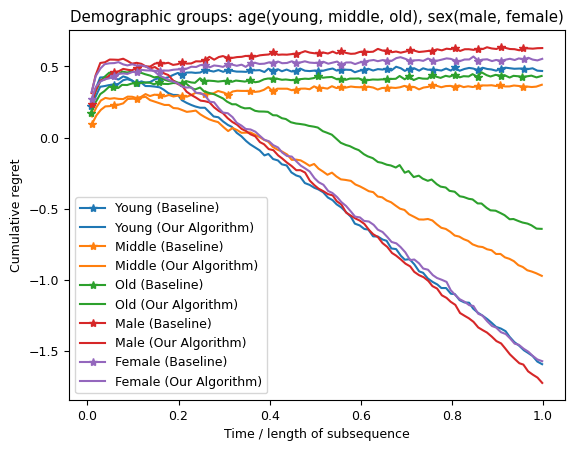

In [31]:
plot_regret_curve_with_std(ds_ob, age_indices+sex_indices, "Demographic groups: age(young, middle, old), sex(male, female)")

smoker 274
non-smoker 1064


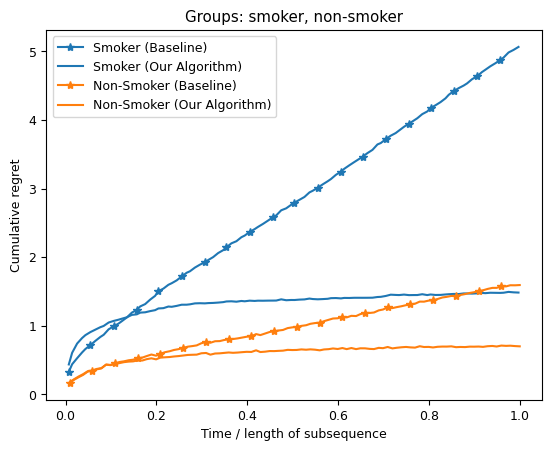

In [32]:
plot_regret_curve_with_std(ds_ob, smoker_indices, "Groups: smoker, non-smoker")

male 676
female 662


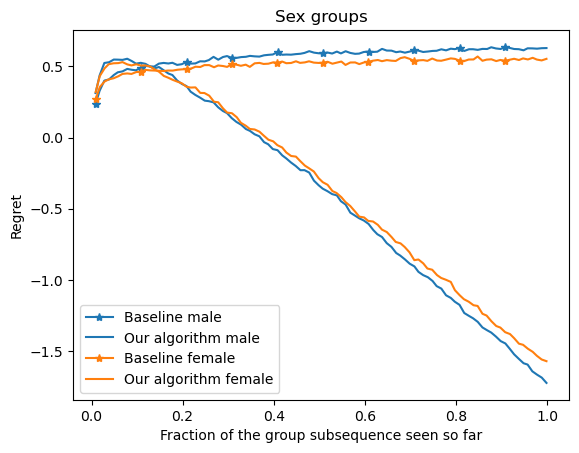

In [94]:
plot_regret_curve_with_std(ds_ob, sex_indices, "Sex groups")

In [141]:
plot_regret_curve_with_std(ds_ob, age_ndi)

TypeError: plot_regret_curve_with_std() missing 1 required positional argument: 'title'

In [17]:
save_ob('medical_gw_expcloss_fair.pkl', ds_ob)

In [8]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [9]:
performance_diff(ds_ob)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,5.866828,0.144624,3.808552,0.188741,2.058276,35.083284
middle,3.706680,0.159263,2.365011,0.172215,1.341669,36.195969
old,3.562693,0.191081,2.489291,0.208740,1.073402,30.128949
underweight,0.168199,0.016382,0.137029,0.017225,0.031170,18.531808
healthyweight,2.527836,0.146259,1.356030,0.059749,1.171806,46.356099
overweight,3.369475,0.176528,2.266466,0.066592,1.103009,32.735327
obese,7.070692,0.324209,4.903330,0.121507,2.167362,30.652754
smoker,5.964842,0.177671,2.384703,0.098569,3.580139,60.020684
non-smoker,7.171359,0.143396,6.278152,0.128886,0.893208,12.455208
male,6.710165,0.240197,4.359355,0.232062,2.350810,35.033565


In [11]:
performance_diff(ds_ob) # with the group indicators included to make a fair comparison to baseline

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,5.866828,0.144624,3.808552,0.188741,2.058276,35.083284
middle,3.706680,0.159263,2.365011,0.172215,1.341669,36.195969
old,3.562693,0.191081,2.489291,0.208740,1.073402,30.128949
underweight,0.168199,0.016382,0.137029,0.017225,0.031170,18.531808
healthyweight,2.527836,0.146259,1.356030,0.059749,1.171806,46.356099
overweight,3.369475,0.176528,2.266466,0.066592,1.103009,32.735327
obese,7.070692,0.324209,4.903330,0.121507,2.167362,30.652754
smoker,5.964842,0.177671,2.384703,0.098569,3.580139,60.020684
non-smoker,7.171359,0.143396,6.278152,0.128886,0.893208,12.455208
male,6.710165,0.240197,4.359355,0.232062,2.350810,35.033565


In [10]:
from bilevel.Groupwise_seedruns import get_end_regret_gw_df

df_regend = get_end_regret_gw_df(ds_ob)

In [11]:
df_regend

,group_name,group_size,mean_regend_Base,std_regend_Base,mean_regend_Anh,std_regend_Anh,mean_hindsight,std_hindsight
0,young,574,0.467087,0.132039,-1.591189,0.178445,5.399741,0.033681
1,middle,408,0.370503,0.149502,-0.971166,0.160602,3.336177,0.009450
2,old,356,0.432216,0.180822,-0.641186,0.191662,3.130477,0.028786
3,underweight,20,0.142358,0.018594,0.111188,0.014274,0.025840,0.008931
4,healthyweight,225,1.523728,0.138809,0.351922,0.056745,1.004107,0.000214
5,overweight,386,1.532713,0.167352,0.429705,0.063155,1.836762,0.000413
6,obese,707,3.419716,0.307216,1.252354,0.114881,3.650976,0.000952
7,smoker,274,5.064594,0.168288,1.484455,0.093663,0.900248,0.000614
8,non-smoker,1064,1.593961,0.124248,0.700753,0.102308,5.577399,0.029372
9,male,676,0.628054,0.224896,-1.722756,0.218132,6.082111,0.012124


In [21]:
df_regend.to_csv('df_regend_medicalcosts.csv')

In [20]:
df_regend['mean_regend_Base'] - df_regend['mean_regend_Anh']

0     2.058276
1     1.341669
2     1.073402
3     0.031170
4     1.171806
5     1.103009
6     2.167362
7     3.580139
8     0.893208
9     2.350810
10    2.122537
11    4.473347
dtype: float64

In [99]:
len()

1338

In [136]:
# batch linear regression, here we want to see the cumulative loss on the ALWAYS ON group
from sklearn.linear_model import LinearRegression
X_dat_tr = df_medical_mm_oh.drop('charges', axis = 1)
y_dat_tr = df_medical_mm_oh['charges']
lr = LinearRegression()
lr.fit(X_dat_tr, y_dat_tr)
print("cumulative squared loss of best in hindsight", np.sum((lr.predict(X_dat_tr) - y_dat_tr)**2))

cumulative squared loss of best in hindsight 12.20888189808186


In [134]:
cumloss_baseline = np.sum(ds_ob.base_obj_list[0].expert.loss_tarr)
print("cumulative loss of baseline", cumloss_baseline)

cumulative loss of baseline 13.299493266661836


In [135]:
cumloss_ouralg = ds_ob.Anh_obj_list[0].Anh.cumloss_ada_allgroups[-1,11]
print("cumulative loss of our algorithm", cumloss_ouralg)

cumulative loss of our algorithm 8.934604272496646


In [137]:
print("r2 score of best in hindsight", lr.score(X_dat_tr, y_dat_tr))
print("r2 score of baseline", 1 - np.sum((baseline_pred_seed473 - y_shuffle_seed473)**2) / np.sum((y_shuffle_seed473 - y_shuffle_seed473.mean())**2))
print("r2 score of our algorithm", 1 -  ds_ob.Anh_obj_list[0].Anh.cumloss_ada_allgroups[-1,11] / np.sum((y_shuffle_seed473 - y_shuffle_seed473.mean())**2))


r2 score of best in hindsight 0.7556133391288826
r2 score of baseline 0.7337824398786232
r2 score of our algorithm 0.8211549491109973


In [128]:
from sklearn.metrics import r2_score
# Baseline r2 score
baseline_pred_seed473 = ds_ob.base_obj_list[0].expert.y_predarr
y_shuffle_seed473 = y_dat_tr.sample(frac=1, random_state=473)
print("cumulative loss of baseline", np.sum((baseline_pred_seed473 - y_shuffle_seed473)**2))
print("r2 score of baseline", r2_score(y_shuffle_seed473, baseline_pred_seed473))

cumulative loss of baseline 13.299493266661836
r2 score of baseline 0.7337824398786232


In [140]:
1 - cumloss_ouralg / cumloss_baseline

0.32819964690735726